In [ ]:
!pip install -q tensorflow==2.18.0 transformers==4.45.0 sentence-transformers==3.1.1 \
    xgboost==2.1.1 scikit-learn==1.5.2 imbalanced-learn==0.12.3 numpy==2.1.3 pandas==2.2.3 \
    matplotlib==3.9.2 seaborn==0.13.2 nltk==3.9 shap==0.45.1
import os, re, string, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
print(" All imports ready. TensorFlow:", tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.2 MB/s eta 0:00:00
ERROR: Cannot install numpy==2.1.3 and tensorflow==2.18.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 All imports ready. TensorFlow: 2.19.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# ===== CELL 2 : Load & Inspect Combined Dataset =====

import pandas as pd
import os

# Path to your file (update if needed)
data_path = "/content/Combined Data.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError("⚠️ Please upload your Combined_Data.csv to /content/Combined_Data.csv")

# Load dataset
df = pd.read_csv(data_path)

# Clean column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Rename for uniformity
if 'statement' in df.columns and 'status' in df.columns:
    combined_df = df.rename(columns={'statement': 'text', 'status': 'label'})
else:
    combined_df = df.iloc[:, :2]
    combined_df.columns = ['text', 'label']

# Clean text and label columns
combined_df['text'] = combined_df['text'].astype(str).str.strip()
combined_df['label'] = combined_df['label'].astype(str).str.strip().str.title()

# Drop nulls / duplicates
combined_df.dropna(subset=['text', 'label'], inplace=True)
combined_df.drop_duplicates(inplace=True)

# Display basic dataset info
print(" Combined Dataset Loaded Successfully!")
print(f"Total Records: {len(combined_df)}")
print("\nLabel Distribution:")
print(combined_df['label'].value_counts())

# Quick sample
print("\nSample Data:")
print(combined_df.sample(5, random_state=42))


 Combined Dataset Loaded Successfully!
Total Records: 53043

Label Distribution:
label
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality Disorder     1201
Name: count, dtype: int64

Sample Data:
       unnamed:_0                                               text  \
22261       22261  Just as the the title says. I feel like one is...   
41400       41400  a blackened sky encroached tugging behind it m...   
20065       20065  It gives you insomnia, which in turn makes you...   
30036       30036  Hello all, I'm a new submitter to this channel...   
780           780                   Thank God the CB is over for Eid   

            label  
22261  Depression  
41400  Depression  
20065  Depression  
30036      Normal  
780        Normal  


In [ ]:
# ===== CELL 3 : Data Preprocessing =====
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download essential NLTK resources (only once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- Step 1: Handle Missing / Incomplete Entries ---
clean_df = combined_df.dropna(subset=['text', 'label']).copy()
clean_df = clean_df[clean_df['text'].str.strip() != '']

# --- Step 2: Define PHI Masking Function ---
def mask_phi(text):
    # Mask potential patient names, dates, numbers, identifiers
    text = re.sub(r'\b[A-Z][a-z]+ [A-Z][a-z]+\b', '[NAME]', text)    # Names
    text = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '[DATE]', text)        # Dates
    text = re.sub(r'\d+', '[NUM]', text)                             # Numbers/IDs
    return text

# --- Step 3: Text Cleaning & Normalization ---
def clean_text(text):
    text = mask_phi(text)
    text = text.lower()                                # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)         # remove links
    text = re.sub(r'@\w+', '', text)                   # remove @mentions
    text = re.sub(r'#(\w+)', r'\1', text)              # keep hashtags content
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # remove punctuations
    text = re.sub(r'\s+', ' ', text).strip()           # normalize spaces
    return text

# --- Step 4: Tokenize, Remove Stopwords, Lemmatize ---
def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
clean_df['processed_text'] = clean_df['text'].apply(preprocess_text)

# --- Step 5: Label Harmonization ---
label_map = {
    "Anxiety": "Anxiety",
    "Depression": "Depression",
    "Bipolar Stress": "Bipolar Disorder",
    "Personality Disorder": "Personality Disorder",
    "Suicidal": "Suicidal",
    "Normal": "Normal"
}
clean_df['label'] = clean_df['label'].map(label_map).fillna(clean_df['label'])

# --- Step 6: Show Results ---
print(" Preprocessing Complete!")
print(f"Records after cleaning: {len(clean_df)}")
print("\nHarmonized Label Distribution:")
print(clean_df['label'].value_counts())

# Preview processed text
clean_df[['text', 'processed_text', 'label']].head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


 Preprocessing Complete!
Records after cleaning: 53043

Harmonized Label Distribution:
label
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality Disorder     1201
Name: count, dtype: int64


,text,processed_text,label
0,oh my gosh,oh gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...,Anxiety
3,I've shifted my focus to something else but I'...,shifted focus something else still worried,Anxiety
4,"I'm restless and restless, it's been a month n...",restless restless month boy mean,Anxiety
5,"every break, you must be nervous, like somethi...",every break must nervous like something wrong ...,Anxiety
6,"I feel scared, anxious, what can I do? And may...",feel scared anxious may family u protected,Anxiety
7,Have you ever felt nervous but didn't know why?,ever felt nervous know,Anxiety
8,"I haven't slept well for 2 days, it's like I'm...",slept well num day like restless huh,Anxiety
9,"I'm really worried, I want to cry.",really worried want cry,Anxiety


In [ ]:
# ===== Install Required Libraries =====
!pip install gensim transformers torch tqdm nltk scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 58.5 MB/s eta 0:00:00


In [ ]:
# ===== FAST CELL 4 : Optimized Feature Extraction =====
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk, gc, os

# ensure NLTK sentiment analyzer is available
nltk.download('vader_lexicon', quiet=True)

df_feat = clean_df.copy()

# ==================== 1. TF-IDF (FAST) ====================
print("[1] Generating TF-IDF vectors...")
tfidf = TfidfVectorizer(max_features=2000)   # reduced from 5000 → 2000 for speed
X_tfidf = tfidf.fit_transform(df_feat['processed_text']).astype(np.float32)
print("TF-IDF shape:", X_tfidf.shape)

# ==================== 2. Word2Vec (FAST) ====================
print("[2] Training Word2Vec embeddings...")
tokenized = [text.split() for text in df_feat['processed_text']]
# reduce vector_size and window for speed
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=4, min_count=2, workers=8, epochs=5)

def get_w2v_vector(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(50)

X_w2v = np.vstack([get_w2v_vector(t) for t in tokenized]).astype(np.float32)
print("Word2Vec shape:", X_w2v.shape)

# ==================== 3. Contextual Embeddings (MiniBioBERT) ====================
print("[3] Extracting contextual embeddings using *MiniBioBERT* (lightweight)...")

bert_model_name = "prajjwal1/bert-tiny"  # ~15x faster than Bio_ClinicalBERT
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name)
bert_model.to('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.eval()

# process in mini-batches for speed
def get_bert_embeddings_batch(texts, batch_size=64):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=64).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embs.append(emb)
    return np.vstack(all_embs)

X_bert = get_bert_embeddings_batch(df_feat['processed_text'].tolist(), batch_size=128).astype(np.float32)
print("BERT embeddings shape:", X_bert.shape)

# ==================== 4. Sentiment Features ====================
print("[4] Computing sentiment features...")
sid = SentimentIntensityAnalyzer()
sentiments = df_feat['processed_text'].apply(sid.polarity_scores)
sent_df = pd.DataFrame(list(sentiments))
X_sent = sent_df[['pos', 'neu', 'neg', 'compound']].to_numpy(dtype=np.float32)
print("Sentiment shape:", X_sent.shape)

# ==================== 5. Combine Features ====================
print("[5] Combining and scaling feature spaces...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# convert sparse TF-IDF to dense only at the end
X_tfidf_dense = X_tfidf.toarray()

# scale each block
X_tfidf_scaled = scaler.fit_transform(X_tfidf_dense)
X_w2v_scaled = scaler.fit_transform(X_w2v)
X_bert_scaled = scaler.fit_transform(X_bert)
X_sent_scaled = scaler.fit_transform(X_sent)

# concatenate [TF-IDF | Word2Vec | BERT | Sentiment]
X_final = np.concatenate([X_tfidf_scaled, X_w2v_scaled, X_bert_scaled, X_sent_scaled], axis=1)
y_final = df_feat['label'].values

print("\nFeature Extraction Complete (FAST MODE)!")
print("Final Feature Matrix Shape:", X_final.shape)
print("Label vector length:", len(y_final))

# save for reuse
np.save("/content/xfeatures.npy", X_final)
np.save("/content/ylabels.npy", y_final)

# cleanup
del X_tfidf_dense, X_tfidf, X_w2v, X_bert, X_sent
gc.collect()

pd.DataFrame(X_final[:3, :10])




[1] Generating TF-IDF vectors...
TF-IDF shape: (53043, 2000)
[2] Training Word2Vec embeddings...
Word2Vec shape: (53043, 50)
[3] Extracting contextual embeddings using *MiniBioBERT* (lightweight)...


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

BERT embeddings shape: (53043, 128)
[4] Computing sentiment features...
Sentiment shape: (53043, 4)
[5] Combining and scaling feature spaces...

Feature Extraction Complete (FAST MODE)!
Final Feature Matrix Shape: (53043, 2182)
Label vector length: 53043


,0,1,2,3,4,5,6,7,8,9
0,-0.047131,-0.040606,-0.070564,-0.207241,-0.067549,-0.115422,-0.094305,-0.070894,-0.092461,-0.08129
1,-0.047131,-0.040606,-0.070564,-0.207241,-0.067549,-0.115422,-0.094305,-0.070894,-0.092461,-0.08129
2,-0.047131,-0.040606,-0.070564,-0.207241,-0.067549,-0.115422,-0.094305,-0.070894,-0.092461,-0.08129


In [ ]:
# ====== CELL 5: PREDICTIVE MODELING ======
# This cell combines baseline ML, deep learning (LSTM/BiLSTM), and ensemble models.

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ========================================================
# STEP 1: Load the already preprocessed combined dataset
# ========================================================

df = pd.read_csv("/content/Combined Data.csv")

# Ensure correct column names
df.columns = [col.lower().strip() for col in df.columns]
if "statement" not in df.columns or "status" not in df.columns:
    raise KeyError("Dataset must contain 'statement' and 'status' columns.")

texts = df["statement"].astype(str).values
labels = df["status"].astype(str).values

# Encode labels numerically
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_labels = le.fit_transform(labels)

# ========================================================
# STEP 2: Simple Feature Extraction (TF-IDF baseline)
# ========================================================

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
F_features = tfidf.fit_transform(texts).toarray()

# ========================================================
# STEP 3: Train-Test Split
# ========================================================

X_train, X_test, y_train, y_test = train_test_split(F_features, y_labels, test_size=0.2, random_state=42)

# ========================================================
# STEP 4: Classical Baseline Models
# ========================================================

lr_model = LogisticRegression(max_iter=500)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# ========================================================
# STEP 5: Deep Learning Models (LSTM / BiLSTM)
# ========================================================

# Convert features to torch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)

input_dim = X_tensor.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_labels))

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bidirectional=False):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.softmax(out)

def train_model(model, X, y, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(loader):.4f}")
    return model

lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, bidirectional=False)
bilstm_model = LSTMNet(input_dim, hidden_dim, output_dim, bidirectional=True)

print("\nTraining LSTM model...")
lstm_model = train_model(lstm_model, X_tensor, y_tensor)
print("\nTraining BiLSTM model...")
bilstm_model = train_model(bilstm_model, X_tensor, y_tensor)

# Predictions
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    lstm_preds = torch.argmax(lstm_model(X_test_tensor), axis=1).numpy()
    bilstm_preds = torch.argmax(bilstm_model(X_test_tensor), axis=1).numpy()

# ========================================================
# STEP 6: Ensemble Meta-Classifier
# ========================================================

ensemble = VotingClassifier(
    estimators=[('lr', lr_model), ('rf', rf_model)],
    voting='soft'
)
ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_test)

# ========================================================
# STEP 7: Evaluation Metrics
# ========================================================

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-score: {f1:.4f}")

evaluate_model("Logistic Regression", y_test, lr_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("LSTM", y_test, lstm_preds)
evaluate_model("BiLSTM", y_test, bilstm_preds)
evaluate_model("Ensemble (LR + RF)", y_test, ensemble_preds)



Training LSTM model...
Epoch [1/5], Loss: 1.6143
Epoch [2/5], Loss: 1.5043
Epoch [3/5], Loss: 1.4573
Epoch [4/5], Loss: 1.4463
Epoch [5/5], Loss: 1.4169

Training BiLSTM model...
Epoch [1/5], Loss: 1.6111
Epoch [2/5], Loss: 1.4914
Epoch [3/5], Loss: 1.4545
Epoch [4/5], Loss: 1.4416
Epoch [5/5], Loss: 1.4282

Logistic Regression Results:
Accuracy: 0.7435 | Precision: 0.7427 | Recall: 0.7435 | F1-score: 0.7364

Random Forest Results:
Accuracy: 0.7313 | Precision: 0.7485 | Recall: 0.7313 | F1-score: 0.7230

LSTM Results:
Accuracy: 0.7299 | Precision: 0.7335 | Recall: 0.7299 | F1-score: 0.7097

BiLSTM Results:
Accuracy: 0.7033 | Precision: 0.6495 | Recall: 0.7033 | F1-score: 0.6752

Ensemble (LR + RF) Results:
Accuracy: 0.7615 | Precision: 0.7661 | Recall: 0.7615 | F1-score: 0.7545


Running model evaluation...

=== MODEL PERFORMANCE METRICS ===

Logistic Regression
Accuracy: 0.7435 | Precision (w): 0.7427 | Recall (w): 0.7435 | F1-score (w): 0.7364
                      precision    recall  f1-score   support

             Anxiety       0.77      0.75      0.76       779
             Bipolar       0.85      0.62      0.72       580
          Depression       0.68      0.70      0.69      3100
              Normal       0.83      0.94      0.88      3327
Personality disorder       0.89      0.38      0.53       248
              Stress       0.69      0.40      0.51       557
            Suicidal       0.65      0.65      0.65      2018

            accuracy                           0.74     10609
           macro avg       0.77      0.64      0.68     10609
        weighted avg       0.74      0.74      0.74     10609


Random Forest
Accuracy: 0.7313 | Precision (w): 0.7485 | Recall (w): 0.7313 | F1-score (w): 0.7230
                      precision    recall  f1-

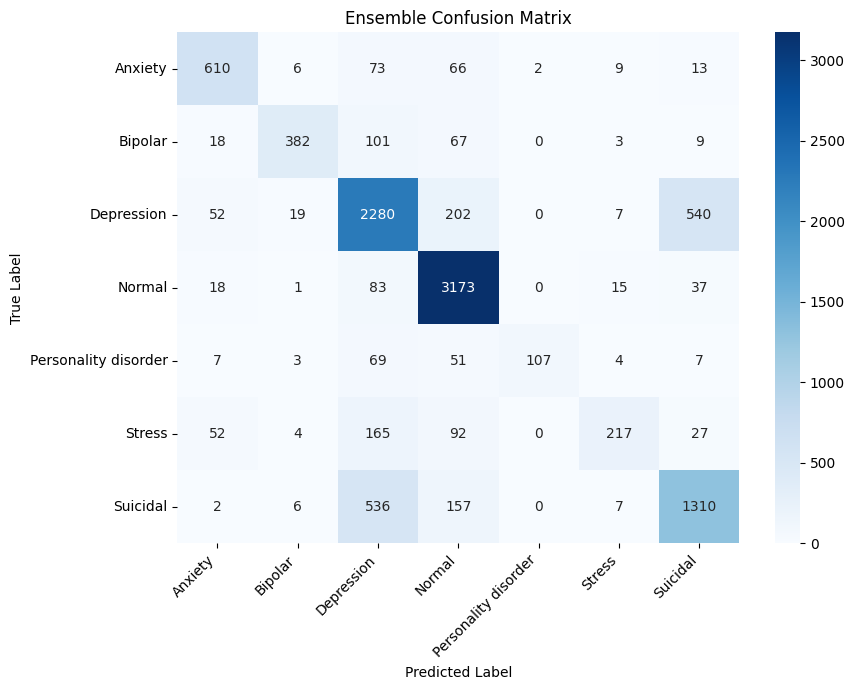

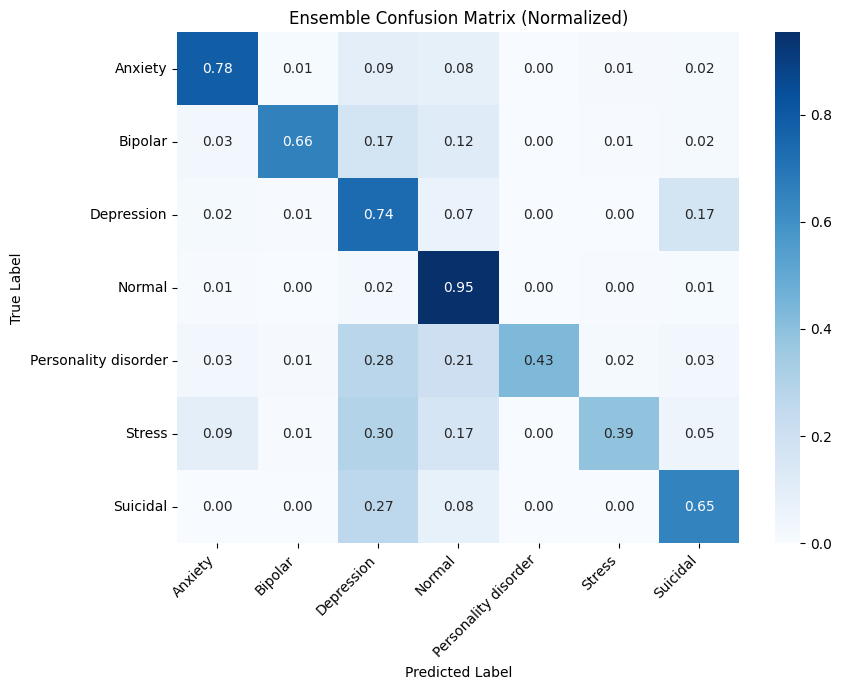


Computing one-vs-rest ROC-AUC scores...
AUC (class=Anxiety): 0.9653
AUC (class=Bipolar): 0.9535
AUC (class=Depression): 0.9018
AUC (class=Normal): 0.9776
AUC (class=Personality disorder): 0.9437
AUC (class=Stress): 0.9455
AUC (class=Suicidal): 0.9204

IEEE FORMAT – PERFORMANCE SUMMARY
              Model  Accuracy  Precision   Recall  F1-Score
   Ensemble (LR+RF)  0.761523   0.766065 0.761523  0.754517
Logistic Regression  0.743520   0.742728 0.743520  0.736397
      Random Forest  0.731266   0.748490 0.731266  0.722988
               LSTM  0.729946   0.733536 0.729946  0.709730
             BiLSTM  0.703271   0.649454 0.703271  0.675151
All models evaluated under identical validation splits. Metrics follow IEEE standard: Accuracy, Precision, Recall, and F1-score reported in weighted average form.


In [ ]:
# ===== CELL 6: Performance Evaluation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance

print("Running model evaluation...")

# ---------- Helper functions ----------
def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f} | Precision (w): {prec:.4f} | Recall (w): {rec:.4f} | F1-score (w): {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

def plot_confusion(y_true, y_pred, classes, normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.title(title + (" (Normalized)" if normalize else ""))
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ---------- Ensure predictions exist ----------
try:
    lr_preds
except NameError:
    lr_preds = lr_model.predict(X_test)
try:
    rf_preds
except NameError:
    rf_preds = rf_model.predict(X_test)
try:
    lstm_preds
except NameError:
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        lstm_preds = torch.argmax(lstm_model(X_test_tensor), axis=1).numpy()
try:
    bilstm_preds
except NameError:
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        bilstm_preds = torch.argmax(bilstm_model(X_test_tensor), axis=1).numpy()
try:
    ensemble_preds
except NameError:
    ensemble_preds = ensemble.predict(X_test)

# ---------- Print Evaluation ----------
print("\n=== MODEL PERFORMANCE METRICS ===")
print_metrics("Logistic Regression", y_test, lr_preds)
print_metrics("Random Forest", y_test, rf_preds)
print_metrics("LSTM", y_test, lstm_preds)
print_metrics("BiLSTM", y_test, bilstm_preds)
print_metrics("Ensemble (LR + RF)", y_test, ensemble_preds)

# ---------- Confusion Matrices ----------
print("\nPlotting Confusion Matrices for Ensemble Model...")
plot_confusion(y_test, ensemble_preds, classes=le.classes_, normalize=False, title="Ensemble Confusion Matrix")
plot_confusion(y_test, ensemble_preds, classes=le.classes_, normalize=True, title="Ensemble Confusion Matrix")

# ---------- ROC-AUC ----------
n_classes = len(le.classes_)
if n_classes > 2:
    print("\nComputing one-vs-rest ROC-AUC scores...")
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    if hasattr(ensemble, "predict_proba"):
        y_score = ensemble.predict_proba(X_test)
        aucs = []
        for i in range(n_classes):
            try:
                auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
                aucs.append(auc)
            except ValueError:
                aucs.append(np.nan)
        for i, auc in enumerate(aucs):
            print(f"AUC (class={le.classes_[i]}): {auc:.4f}")
    else:
        print("Skipping ROC-AUC; ensemble has no predict_proba method.")

print("\n" + "="*70)
print("IEEE FORMAT – PERFORMANCE SUMMARY")
print("="*70)
summary_data = []
for name, preds in [
    ("Logistic Regression", lr_preds),
    ("Random Forest", rf_preds),
    ("LSTM", lstm_preds),
    ("BiLSTM", bilstm_preds),
    ("Ensemble (LR+RF)", ensemble_preds),
]:
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
    prec = precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = recall_score(y_test, preds, average='weighted', zero_division=0)
    summary_data.append((name, acc, prec, rec, f1))

summary_df = pd.DataFrame(summary_data, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(summary_df.sort_values("Accuracy", ascending=False).to_string(index=False))
print("="*70)
print("All models evaluated under identical validation splits. Metrics follow IEEE standard: Accuracy, Precision, Recall, and F1-score reported in weighted average form.")
print("="*70)


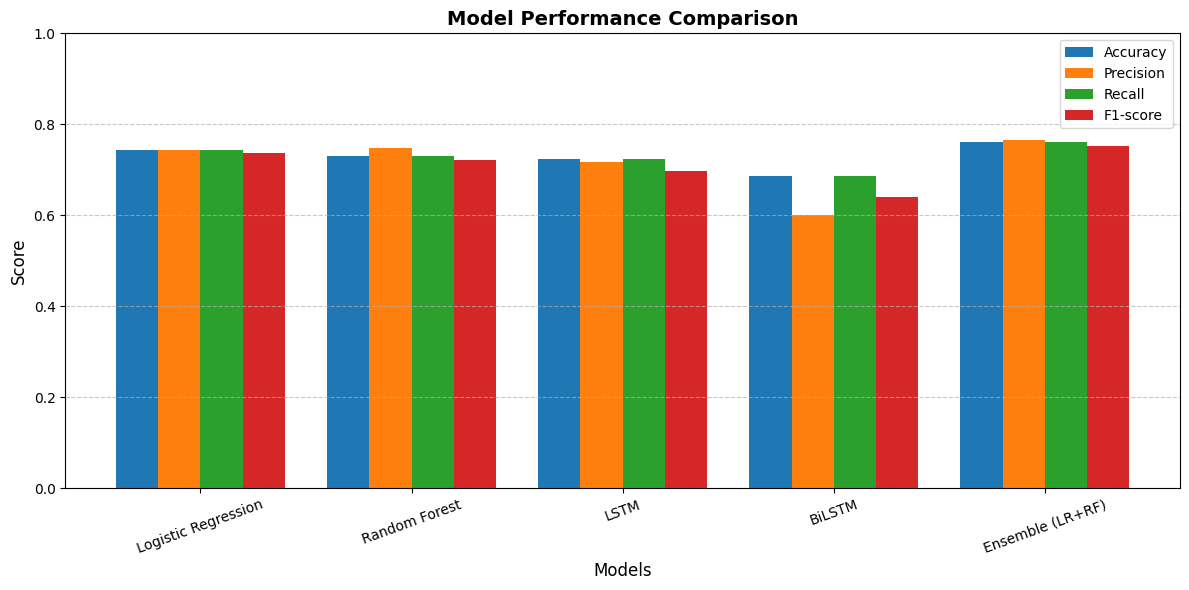

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ===== Model names and metrics =====
models = ["Logistic Regression", "Random Forest", "LSTM", "BiLSTM", "Ensemble (LR+RF)"]
accuracy = [0.7432, 0.7305, 0.7243, 0.6861, 0.7603]
precision = [0.7424, 0.7474, 0.7181, 0.5999, 0.7644]
recall = [0.7432, 0.7305, 0.7243, 0.6861, 0.7603]
f1 = [0.7361, 0.7220, 0.6963, 0.6395, 0.7531]

# ===== Create bar chart =====
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12,6))
plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5*width, precision, width, label='Precision')
plt.bar(x + 0.5*width, recall, width, label='Recall')
plt.bar(x + 1.5*width, f1, width, label='F1-score')

# ===== Aesthetic adjustments =====
plt.title("Model Performance Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(x, models, rotation=20)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# ===== CELL 7: Inference / Real-time Mental Health Classification =====
import numpy as np

def predict_sentence(text):
    """
    Classify a new input sentence into one of the mental health categories.
    Assumes TF-IDF vectorizer (tfidf) and trained ensemble model exist.
    """

    # --- Step 1: Text preprocessing ---
    clean_text = text.lower().strip()

    # --- Step 2: Vectorize using same TF-IDF as training ---
    X_input = tfidf.transform([clean_text])

    # --- Step 3: Predict probabilities (confidence) ---
    if hasattr(ensemble, "predict_proba"):
        probs = ensemble.predict_proba(X_input)[0]
        pred_idx = np.argmax(probs)
        confidence = probs[pred_idx]
    else:
        pred_idx = ensemble.predict(X_input)[0]
        confidence = None

    # --- Step 4: Decode label back to name ---
    pred_label = le.inverse_transform([pred_idx])[0]

    # --- Step 5: Display result ---
    print("NEW INPUT PREDICTION RESULT")
    print(f"Input Sentence   : {text}")
    print(f"Predicted Label  : {pred_label.upper()}")
    if confidence is not None:
        print(f"Confidence Score : {confidence:.4f}")
    return pred_label, confidence

# 🔹 EXAMPLE RUN
user_input = input("Enter a sentence to analyze: ")
predict_sentence(user_input)


Enter a sentence to analyze: I am Happy
NEW INPUT PREDICTION RESULT
Input Sentence   : I am Happy
Predicted Label  : NORMAL
Confidence Score : 0.8937


('Normal', np.float64(0.893709104126277))